In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as mtp
import seaborn as sb
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import r2_score

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
data = pd.read_csv("sample_data/deliverytime.csv")
display(data)

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,Sunny,High,2,Snack,motorcycle,0,No,Urban,24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,Cloudy,High,1,Snack,scooter,1,No,Metropolitian,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56987,0x6909,JAPRES01DEL01,35,4.6,26.905190,75.810753,27.015190,75.920753,27-03-2022,21:35:00,21:45:00,Sunny,Jam,1,Snack,scooter,1,No,Metropolitian,22
56988,0x443b,JAPRES11DEL01,33,4.9,26.902940,75.793007,26.912940,75.803007,11-03-2022,11:40:00,11:45:00,Sandstorms,High,1,Drinks,scooter,1,No,Metropolitian,29
56989,0x1ea5,SURRES11DEL03,NaN,NaN,21.157735,72.768778,21.217735,72.828778,11-03-2022,NaN,21:05:00,NaN,NaN,3,Drinks,scooter,1,No,Metropolitian,26
56990,0x22d4,VADRES03DEL02,27,4.7,22.320000,73.170000,22.450000,73.300000,06-03-2022,18:35:00,18:40:00,Sandstorms,Medium,0,Meal,motorcycle,0,No,Metropolitian,24


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56992 entries, 0 to 56991
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           56992 non-null  object 
 1   Delivery_person_ID           56992 non-null  object 
 2   Delivery_person_Age          56992 non-null  object 
 3   Delivery_person_Ratings      56992 non-null  object 
 4   Restaurant_latitude          56992 non-null  float64
 5   Restaurant_longitude         56992 non-null  float64
 6   Delivery_location_latitude   56992 non-null  float64
 7   Delivery_location_longitude  56992 non-null  float64
 8   Order_Date                   56992 non-null  object 
 9   Time_Orderd                  56992 non-null  object 
 10  Time_Order_picked            56992 non-null  object 
 11  Weatherconditions            56218 non-null  object 
 12  Road_traffic_density         56992 non-null  object 
 13  Vehicle_conditio

In [ ]:
# finding all types of null values
data2 = data.astype(str)

null_types = set()

for col in data2.columns:
    unique_vals = data2[col].unique()
    
    for val in unique_vals:
        if 'nan' in val.lower():
            null_types.add(val)
            
print(null_types)


# corecting null values to np.nan
for na_value in null_types:
    data.replace(na_value, np.nan, inplace=True)

{'nan', 'NaN '}


In [ ]:
# checking for null values again
data.isna().sum()

ID                                0
Delivery_person_ID                0
Delivery_person_Age            2345
Delivery_person_Ratings        2415
Restaurant_latitude               0
Restaurant_longitude              0
Delivery_location_latitude        0
Delivery_location_longitude       0
Order_Date                        0
Time_Orderd                    2175
Time_Order_picked                 0
Weatherconditions               774
Road_traffic_density            755
Vehicle_condition                 0
Type_of_order                     0
Type_of_vehicle                   0
multiple_deliveries            1231
Festival                        293
City                           1524
Time_taken(min)                   0
dtype: int64

In [ ]:
# computing distance from restaurant to delivery location
data['distance_km'] = np.zeros(len(data))


restaurant_coordinates = data[['Restaurant_latitude','Restaurant_longitude']].to_numpy()
delivery_location_coordinates = data[['Delivery_location_latitude','Delivery_location_longitude']].to_numpy()

# calculating distance (Vincenty formula)
for i in range(len(data)):
    data['distance_km'].loc[i] = geodesic(restaurant_coordinates[i],delivery_location_coordinates[i]).km

# dropping lat long cols
data = data.drop(columns = ['Restaurant_latitude','Restaurant_longitude','Delivery_location_latitude','Delivery_location_longitude'])

In [ ]:
# adding column for average speed
data['avg_speed_kmph'] = round((data['distance_km']*60) / data['Time_taken(min)'])

In [ ]:
# missing data handling
imputerr = SimpleImputer(missing_values=np.nan, strategy='mean')
data['Delivery_person_Ratings'] = imputerr.fit_transform(data[['Delivery_person_Ratings']])
data['Delivery_person_Age'] = imputerr.fit_transform(data[['Delivery_person_Age']])

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
data['Weatherconditions'] = imputer.fit_transform(data[['Weatherconditions']])
data['Road_traffic_density'] = imputer.fit_transform(data[['Road_traffic_density']])
data['multiple_deliveries'] = imputer.fit_transform(data[['multiple_deliveries']])
data['Festival'] = imputer.fit_transform(data[['Festival']])
data['City'] = imputer.fit_transform(data[['City']])

data[['multiple_deliveries']] = data[['multiple_deliveries']].astype(str).astype(int)
data[['Delivery_person_Ratings']] = data[['Delivery_person_Ratings']].astype(str).astype(float)
data[['Delivery_person_Age']] = data[['Delivery_person_Age']].astype(str).astype(float).astype(int)


In [ ]:
display(data)

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),distance_km,avg_speed_kmph
0,0x4607,INDORES13DEL02,37,4.900000,19-03-2022,11:30:00,11:45:00,Sunny,High,2,Snack,motorcycle,0,No,Urban,24,3.020737,8.0
1,0xb379,BANGRES18DEL02,34,4.500000,25-03-2022,19:45:00,19:50:00,Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,33,20.143737,37.0
2,0x5d6d,BANGRES19DEL01,23,4.400000,19-03-2022,08:30:00,08:45:00,Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,26,1.549693,4.0
3,0x7a6a,COIMBRES13DEL02,38,4.700000,05-04-2022,18:00:00,18:10:00,Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,21,7.774497,22.0
4,0x70a2,CHENRES12DEL01,32,4.600000,26-03-2022,13:30:00,13:45:00,Cloudy,High,1,Snack,scooter,1,No,Metropolitian,30,6.197898,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56987,0x6909,JAPRES01DEL01,35,4.600000,27-03-2022,21:35:00,21:45:00,Sunny,Jam,1,Snack,scooter,1,No,Metropolitian,22,16.365894,45.0
56988,0x443b,JAPRES11DEL01,33,4.900000,11-03-2022,11:40:00,11:45:00,Sandstorms,High,1,Drinks,scooter,1,No,Metropolitian,29,1.488108,3.0
56989,0x1ea5,SURRES11DEL03,29,4.633582,11-03-2022,NaN,21:05:00,Fog,Low,3,Drinks,scooter,1,No,Metropolitian,26,9.107659,21.0
56990,0x22d4,VADRES03DEL02,27,4.700000,06-03-2022,18:35:00,18:40:00,Sandstorms,Medium,0,Meal,motorcycle,0,No,Metropolitian,24,19.658584,49.0


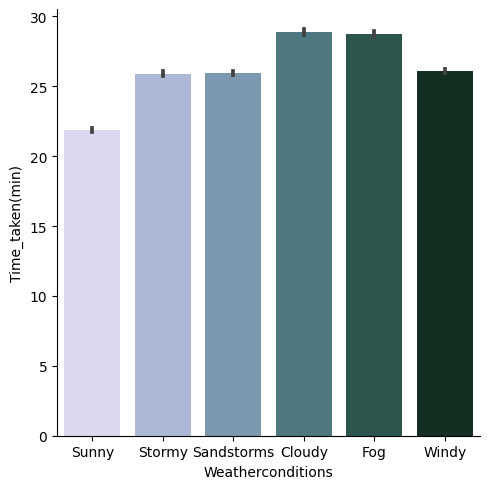

In [ ]:
sb.catplot(data=data, x="Weatherconditions", y="Time_taken(min)", kind="bar", palette="ch: 5")

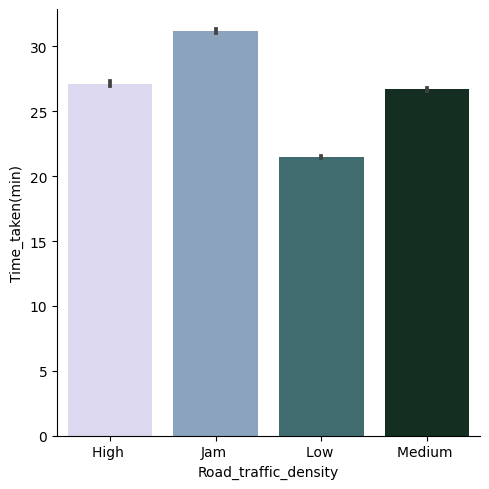

In [ ]:
sb.catplot(data=data, x="Road_traffic_density", y="Time_taken(min)", kind="bar", palette="ch: 5")

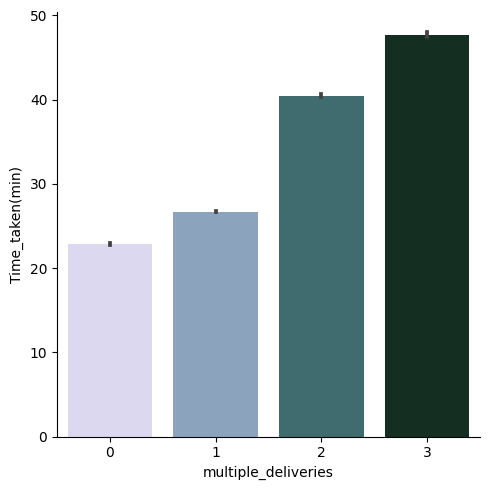

In [ ]:
sb.catplot(data=data, x="multiple_deliveries", y="Time_taken(min)", kind="bar", palette="ch: 5")

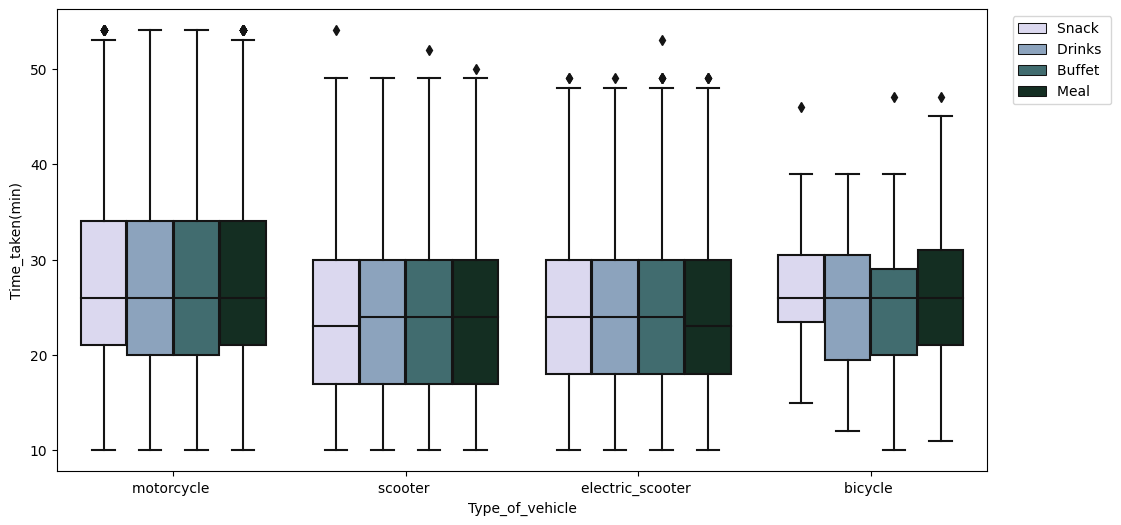

In [ ]:
mtp.figure(figsize = (12,6))
sb.boxplot(data=data, x="Type_of_vehicle", y="Time_taken(min)", hue="Type_of_order", palette="ch: 5")
mtp.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

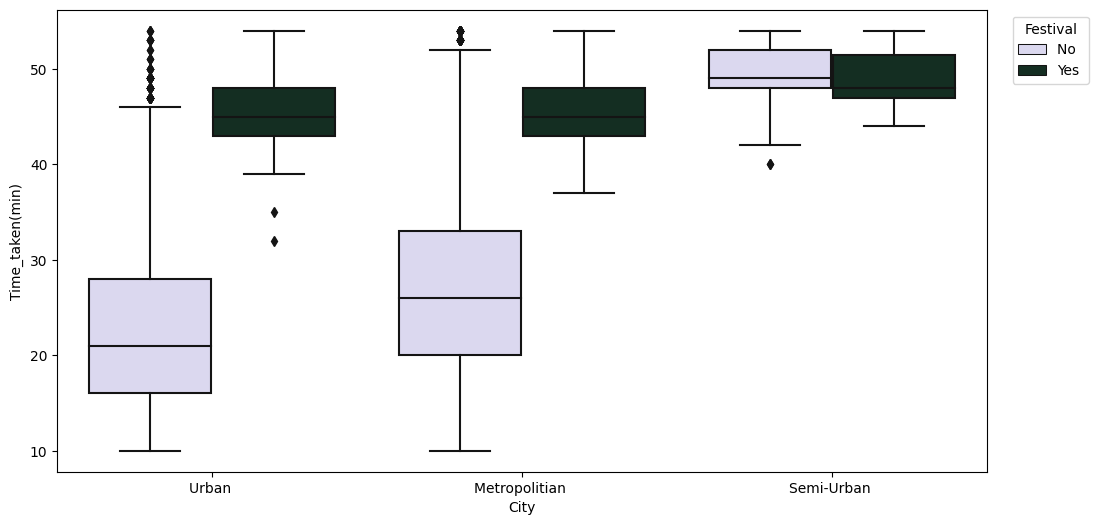

In [ ]:
mtp.figure(figsize = (12,6))
sb.boxplot(data=data, x="City", y="Time_taken(min)", hue="Festival", palette="ch: 5")
mtp.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title="Festival")

In [ ]:
# Difference between average speeds of under 30 and over 30 drivers

under_30 = data[data['Delivery_person_Age']<30]['avg_speed_kmph'].mean()
above_30 = data[data['Delivery_person_Age']>=30]['avg_speed_kmph'].mean()

print(f'Average speed of persons under 30 : {round(under_30,2)} kmph')
print(f'Average speed of persons above 30 : {round(above_30,2)} kmph')

Average speed of persons under 30 : 404.74 kmph
Average speed of persons above 30 : 106.46 kmph


In [ ]:
# categorical data handling
le = LabelEncoder()
print(data['Road_traffic_density'].unique())
data['Road_traffic_density'] = le.fit_transform(data['Road_traffic_density'])
print(data['Road_traffic_density'].unique())

print(data['Weatherconditions'].unique())
data['Weatherconditions'] = le.fit_transform(data['Weatherconditions'])
print(data['Weatherconditions'].unique())

print(data['Type_of_order'].unique())
data['Type_of_order'] = le.fit_transform(data['Type_of_order'])
print(data['Type_of_order'].unique())

print(data['Type_of_vehicle'].unique())
data['Type_of_vehicle'] = le.fit_transform(data['Type_of_vehicle'])
print(data['Type_of_vehicle'].unique())

print(data['Festival'].unique())
data['Festival'] = le.fit_transform(data['Festival'])
print(data['Festival'].unique())

print(data['City'].unique())
data['City'] = le.fit_transform(data['City'])
print(data['City'].unique())

['High ' 'Jam ' 'Low ' 'Medium ']
[0 1 2 3]
['Sunny' 'Stormy' 'Sandstorms' 'Cloudy' 'Fog' 'Windy']
[4 3 2 0 1 5]
['Snack ' 'Drinks ' 'Buffet ' 'Meal ']
[3 1 0 2]
['motorcycle ' 'scooter ' 'electric_scooter ' 'bicycle ']
[2 3 1 0]
['No ' 'Yes ']
[0 1]
['Urban ' 'Metropolitian ' 'Semi-Urban ']
[2 0 1]


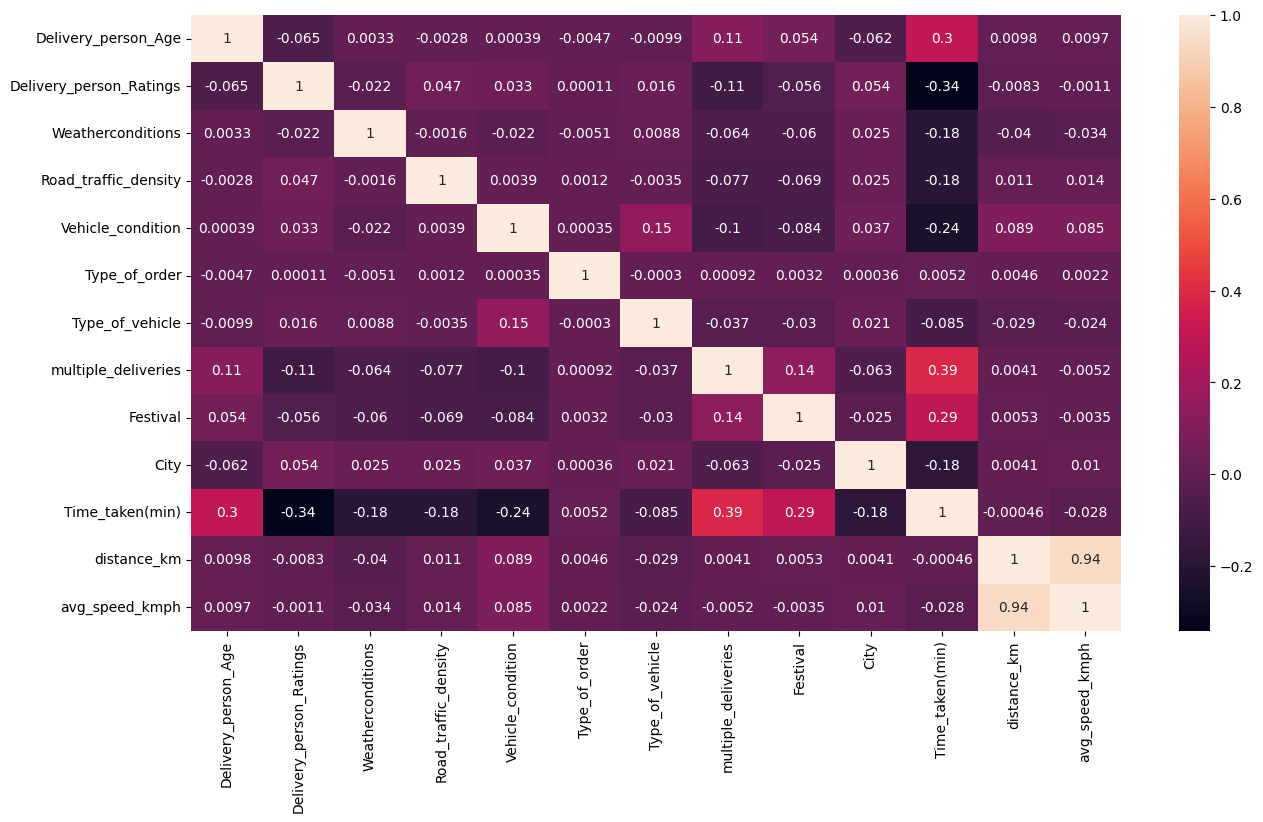

In [ ]:
# heat map
mtp.figure(figsize = (15,8))
sb.heatmap(data.corr(), annot=True)
mtp.show()

In [ ]:
x = np.array(data[["Delivery_person_Age","Delivery_person_Ratings",
                   "Weatherconditions","Road_traffic_density",
                   "Vehicle_condition","multiple_deliveries",
                   "Festival","City"]])

y = np.array(data[["Time_taken(min)"]])

In [ ]:
# Splitting the dataset into the Training set and Test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

# Feature Scaling
# standardization : mean=0 and standard deviation=1
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [ ]:
# LSTMs use the tanh activation function((e^(x)-e^(-x))/(e^(x)+e^(-x))) for the activation of the cell state - range[-1,1]
# and the sigmoid activation function (1/(1+e^(-x))) for the node output.  -   range [0,1]
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(x_train.shape[1],1)))              # 4*(1+64+1)*64 = 16896
model.add(LSTM(32, return_sequences=True))                                                # 4*(64+32+1)*32 = 12416
model.add(LSTM(16, return_sequences=True))                                                # 4*(32+16+1)*16 = 3136
model.add(LSTM(8, return_sequences=False))                                                # 4*(16+8+1)*8 = 800
model.add(Dense(1, activation="linear"))                                                  # 8+1 = 9
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8, 64)             16896     
                                                                 
 lstm_1 (LSTM)               (None, 8, 32)             12416     
                                                                 
 lstm_2 (LSTM)               (None, 8, 16)             3136      
                                                                 
 lstm_3 (LSTM)               (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 33,257
Trainable params: 33,257
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Optimizers are Classes or methods used to change the attributes of your model such as weights and learning rate in order to reduce the losses.
# Adam optimization is a stochastic gradient descent method 
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=50)

Epoch 1/50
42744/42744 [==============================] - 338s 8ms/step - loss: 75.5499
Epoch 2/50
42744/42744 [==============================] - 325s 8ms/step - loss: 29.7049
Epoch 3/50
42744/42744 [==============================] - 322s 8ms/step - loss: 25.2452
Epoch 4/50
42744/42744 [==============================] - 324s 8ms/step - loss: 23.6000
Epoch 5/50
42744/42744 [==============================] - 324s 8ms/step - loss: 22.6716
Epoch 6/50
42744/42744 [==============================] - 325s 8ms/step - loss: 22.3717
Epoch 7/50
42744/42744 [==============================] - 327s 8ms/step - loss: 22.0795
Epoch 8/50
42744/42744 [==============================] - 321s 8ms/step - loss: 21.8431
Epoch 9/50
42744/42744 [==============================] - 316s 7ms/step - loss: 21.6242
Epoch 10/50
42744/42744 [==============================] - 321s 8ms/step - loss: 21.5559
Epoch 11/50
42744/42744 [==============================] - 320s 7ms/step - loss: 21.4181
Epoch 12/50
42744/42744 [=====

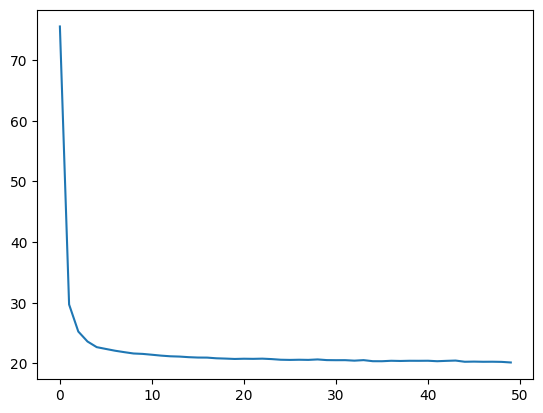

In [ ]:
loss_per_epoch = model.history.history['loss']
mtp.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [ ]:
y_pred = model.predict(x_train)

1336/1336 [==============================] - 9s 5ms/step


In [ ]:
y_predT = model.predict(x_test)

446/446 [==============================] - 2s 4ms/step


In [ ]:
print("accuracy : ", round((r2_score(y_train, y_pred)*100),2), "%")

accuracy :  76.67 %


In [ ]:
# r2 = 1 - (((y_test(i)-y_predT(i))^2)/((y_test(i)-y_mean)^2)) = 1 - (MSE/y_variance)
print("accuracy : ", round((r2_score(y_test, y_predT)*100),2), "%")

accuracy :  74.64 %


In [ ]:
age = int(input("Enter Delivery Person Age... "))

rating = float(input("Enter Delivery Person Rating (0-5)... "))
if rating<0 or rating>5 : exit(101)

weather = int(input("Enter Weather condition... \n0-Cloudy  1-Fog  2-Sandstorms  3-Stormy  4-Sunny  5-Windy   "))
if weather<0 or weather>5 : exit(101)

traffic = int(input("Enter Road Traffic Density... \n0-High  1-Jam  2-Low  3-Medium   "))
if traffic<0 or traffic>4 : exit(101)

vehicle_condition = int(input("Enter Vehicle Condition (0-3)..."))
if vehicle_condition<0 or vehicle_condition>3 : exit(101)

order = int(input("Enter your Order... \n0-Buffet  1-Drinks  2-Meal  3-Snack   "))
if order<0 or order>3 : exit(101)

vehicle = int(input("Enter Vehicle Type... \n0-bicycle  1-electric_scooter  2-motorcycle  3-scooter   "))
# if vehicle<0 or vehicle>3 : exit(101)

multiple_deliveries = int(input("Enter Multiple Deliveries (0-3)... "))
if multiple_deliveries<0 or multiple_deliveries>0 : exit(101)

festival = int(input("Enter Festival... \n0-No  1-Yes   "))
if festival<0 or festival>1 : exit(101)

city = int(input("Enter City... \n0-Metropolitian  1-Semi-Urban  2-Urban   "))
if city<0 or city>2 : exit(101)

dist = float(input("Enter Distance in km... "))

data1 = np.array([[age,rating,weather,traffic,vehicle_condition,multiple_deliveries,festival,city]])
time = model.predict(data1)
print("\nExpected Time : ",time,"min")

Enter Delivery Person Age... 27
Enter Delivery Person Rating (0-5)... 4.7
Enter Weather condition... 
0-Cloudy  1-Fog  2-Sandstorms  3-Stormy  4-Sunny  5-Windy   2
Enter Road Traffic Density... 
0-High  1-Jam  2-Low  3-Medium   3
Enter Vehicle Condition (0-3)...0
Enter your Order... 
0-Buffet  1-Drinks  2-Meal  3-Snack   2
Enter Vehicle Type... 
0-bicycle  1-electric_scooter  2-motorcycle  3-scooter   2
Enter Multiple Deliveries (0-3)... 0
Enter Festival... 
0-No  1-Yes   0
Enter City... 
0-Metropolitian  1-Semi-Urban  2-Urban   0
Enter Distance in km... 19.65
1/1 [==============================] - 1s 1s/step

Expected Time :  [[22.107248]] min
